# First project: apple fruits detector

## Workflow
![apple detector workflow](img_embed/w9_apple_detector_wf.webp)

## Setup

In [1]:
import cv2 as cv
import numpy as np
from pathlib import Path

## Parse the xml to get the image metadata

In [2]:
import xml.etree.ElementTree as ET

def read_xml(xmlFile: str) -> dict:
    root = ET.parse(xmlFile).getroot()
    boxes = {"filename": root.find("filename").text, 
            "class_name": [],
            "bounding_box": []}
    for box in root.iter("object"):
        boxes["class_name"].append(box.find("name").text)
        bb = box.find("bndbox")
        obj = {
            "xmin": int(bb.find("xmin").text),
            "xmax": int(bb.find("xmax").text),
            "ymin": int(bb.find("ymin").text),
            "ymax": int(bb.find("ymax").text)
        }
        boxes["bounding_box"].append(obj)

    return boxes

### test the function

In [3]:
xml_file_path = "images/w9/fruits_obj_det/train_zip/train/apple_1.xml"
read_xml(xml_file_path)

{'filename': 'apple_1.jpg',
 'class_name': ['apple'],
 'bounding_box': [{'xmin': 8, 'xmax': 331, 'ymin': 15, 'ymax': 349}]}

In [4]:
xml_file_path = "images/w9/fruits_obj_det/train_zip/train/mixed_1.xml"
read_xml(xml_file_path)

{'filename': 'mixed_1.jpg',
 'class_name': ['orange', 'apple', 'banana'],
 'bounding_box': [{'xmin': 221, 'xmax': 463, 'ymin': 83, 'ymax': 338},
  {'xmin': 440, 'xmax': 666, 'ymin': 148, 'ymax': 404},
  {'xmin': 54, 'xmax': 627, 'ymin': 228, 'ymax': 528}]}

## Get the postive instances
Extract the HOG descriptor on apple cropped images (positives).

In [5]:
# Hyperparameters for HOG descriptor
winSize = (128, 128)
blockSize = (32, 32)
blockStride = (16, 16)
cellSize = (16, 16)
nbins = 9

base_path = Path() / "images" / "w9" / "fruits_obj_det"
train_img_path = base_path / "train_zip" / "train"

positives = []

for xmlFile in train_img_path.glob("*.xml"):
    metadata = read_xml(xmlFile)
    if "apple" in metadata["class_name"]:
        filename = metadata['filename']
        indices = [i for i, x in enumerate(metadata["class_name"]) if x == "apple"]
        # get image
        img = cv.imread(str(train_img_path / filename))
        if img is not None:
            # get bounding box
            for index in indices:
                box = metadata["bounding_box"][index]
                xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
                sample = img[ymin:ymax, xmin:xmax]
                sample = cv.resize(sample, winSize, cv.INTER_CUBIC)
                positives.append(sample)

In [6]:
print("The number of apple cropped images: ", len(positives))

The number of apple cropped images:  156


## get the negative instances

In [7]:
# test_img_path = base_path / "train_zip" / "train"
negative_classes = ("banana", "orange")

negatives = []

for xmlFile in train_img_path.glob("*.xml"):
    metadata = read_xml(xmlFile)
    if bool(set(negative_classes) & set(metadata["class_name"])):
        filename = metadata['filename']
        indices = [i for i, x in enumerate(metadata["class_name"]) if x != "apple"]
        # get image
        img = cv.imread(str(train_img_path / filename))
        if img is not None:
            # get bounding box
            for index in indices:
                box = metadata["bounding_box"][index]
                xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
                sample = img[ymin:ymax, xmin:xmax]
                sample = cv.resize(sample, winSize, cv.INTER_CUBIC)
                negatives.append(sample)

In [8]:
print("The number of negative cropped images: ", len(negatives))

The number of negative cropped images:  309


## Perform HOG feature extraction on positive and negative images

In [9]:
# Prepare the dataset
images = positives + negatives
labels = ([1] * len(positives)) + ([0] * len(negatives))
# set up the HOG feature descriptor
hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

In [10]:
X_train = []

for img in images:
    features = hog.compute(img)
    X_train.append(features.ravel())

In [11]:
X_train = np.array(X_train).astype("float32")
y_train = np.array(labels).astype("int32")

print("The shape of training data: ", X_train.shape)
print("The shape of training labels: ", y_train.shape)

The shape of training data:  (465, 1764)
The shape of training labels:  (465,)


## train SVM classifier

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import LinearSVC

param_distrib = {
    'C': uniform(1, 100),
    'loss': ["hinge", "squared_hinge"]
}
linear_svc = LinearSVC(random_state=5)
rnd_search_cv = RandomizedSearchCV(linear_svc, param_distrib, n_iter=100, cv=5,
                                  random_state=11, n_jobs=-1)
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=5), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002330271AA80>,
                                        'loss': ['hinge', 'squared_hinge']},
                   random_state=11)

In [15]:
svm = rnd_search_cv.best_estimator_
print("Cross validation training accuracy: ", round(rnd_search_cv.best_score_))

Cross validation training accuracy:  1


In [17]:
svm

LinearSVC(C=19.02696888767692, loss='hinge', random_state=5)

In [16]:
svm.coef_

array([[-0.32344245,  0.65329513,  0.735803  , ...,  0.18992225,
        -0.15186946, -0.3855259 ]])

In [18]:
svm_coef = svm.coef_[0]
svm_intercept = svm.intercept_[0]

svm_coefficients = np.append(svm_coef, svm_intercept)
svm_coefficients

array([-0.32344245,  0.65329513,  0.735803  , ..., -0.15186946,
       -0.3855259 , -1.77142213])

At this point, we have to save SVM model coefficients so that we can load these parameters when in need.

In [19]:
filename = "object_det/hog_svm/hog_svm_coef.npy"

with open(filename, "wb") as f:
    np.save(f, svm_coefficients)

In [20]:
hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

with open(filename, "rb") as f:
    svm_coefficients = np.load(f)

hog.setSVMDetector(svm_coefficients)

## Define NMS to filter out unwanted bounding box

In [21]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = start_x + boxes[:, 2]
    end_y = start_y + boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

## Test with some images

### Test image 1

In [22]:
from utils import display_image, matplotlib_show_images
# import os

In [32]:
# chaoose between 77-95
idx = 93
test_img = cv.imread(f"images/w9/fruits_obj_det/test_zip/test/apple_{idx}.jpg")
locations, scores = hog.detectMultiScale(test_img)
if not locations.any():
    print("No bounding box detected!")
else:
    boxes, _ = nms(locations, scores, 0.5)

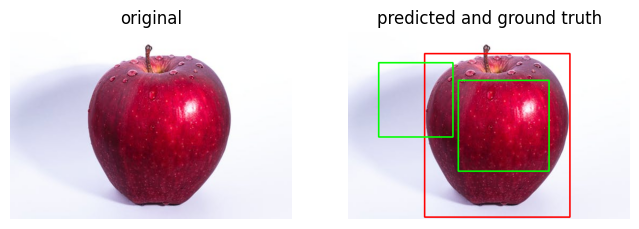

In [33]:
test_img_copy = test_img.copy()
test_img_metadata = read_xml(f"images/w9/fruits_obj_det/test_zip/test/apple_{idx}.xml")

# draw ground truths
indices = [i for i, x in enumerate(test_img_metadata["class_name"]) if x == "apple"]
for index in indices:
    box = test_img_metadata["bounding_box"][index]
    xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
    cv.rectangle(test_img_copy, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    
# draw detected bounding box
for x, y, w, h in boxes:
    cv.rectangle(test_img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

display_image("bb", test_img_copy)
cv.imwrite(f"object_det/hog_svm/res_{idx}.jpg", test_img_copy)
matplotlib_show_images([cv.cvtColor(test_img, cv.COLOR_BGR2RGB), cv.cvtColor(test_img_copy, cv.COLOR_BGR2RGB)], 1, 2, 
                      titles=("original", "predicted and ground truth"), figsize=(8, 4))

The red bounding boxes are the ground truth and green bounding boxes are the predicted bounding boxes.

In [41]:
%run apple_obj_detector.py --imagePath images/w9/fruits_obj_det/test_zip/test/mixed_25.jpg

# Project: Car plates detection

## Workflow
![car plate detection](img_embed/w9_car_plate_detection.webp)

## Setup

In [42]:
import cv2 as cv
import numpy as np
from utils import display_image, gamma_correction
import os

In [43]:
img = cv.imread("images/w9/malaysia_car_plate/car1.jpeg")
gamma = 0.7
img = gamma_correction(img, gamma=gamma)
display_image("gamma", img)

## MobileNet + SSD
Define:
1. Configuration file
2. Model weights file
3. List of classes

The model files can be found in this [GitHub repo](https://github.com/djmv/MobilNet_SSD_opencv.git).
```
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
```

The class that we want to detect is class index 7: car.

In [45]:
model_prototxt = "object_det/mobilenet_ssd/MobileNetSSD_deploy.prototxt"
model_path = "object_det/mobilenet_ssd/MobileNetSSD_deploy.caffemodel"

net = cv.dnn.readNetFromCaffe(model_prototxt, model_path)

In [46]:
# define the corresponding input image size, scaling factor and mean
blob = cv.dnn.blobFromImage(img, scalefactor=1 / 127.5, size=(400, 400),
                           mean=(127.5, 127.5, 127.5), swapRB=True, crop=False)

net.setInput(blob)

detections = net.forward()

The detections is a Numpy array with 4 dimensions. The third dimension is the number of bounding box. There are 4 elements in the 4th dimension. Each of them represents:
1. image_id: ID of image in the batch
2. label: predicted class id
3. conf: confidence score of the predicted class
4. xmin
5. ymin
6. xmax
7. ymax

In [47]:
minimum_area = 100

def areaFilter(x):
    if cv.contourArea(x) > minimum_area:
        return True
    else:
        return False

In [48]:
h, w = img.shape[:2]
CLASS_ID = 7
confidence_threshold = 0.2
# img_copy = img.copy()
rect_kernel = cv.getStructuringElement(cv.MORPH_RECT, (12, 6))
# initialize box coordinates and detected list
box_coordinates = []

for i in range(detections.shape[2]):
    # extract the confidence and class id
    confidence = detections[0, 0, i, 2]
    class_id = detections[0, 0, i, 1]
    # we need the car prediction
    if class_id == CLASS_ID and confidence > confidence_threshold:
        # bounding box extraction
        box = detections[0, 0, i, 3:] * np.array([w, h, w, h])
        xmin, ymin, xmax, ymax = box.astype("int")

        # apply car plate detection pipeline
        car_img = img[ymin:ymax, xmin:xmax]
        # grayscale
        gray = cv.cvtColor(car_img, cv.COLOR_BGR2GRAY)
        # tophat morphology
        whitehat = cv.morphologyEx(gray, cv.MORPH_TOPHAT, rect_kernel)
        # Scharr x
        scharrX = cv.Sobel(whitehat, cv.CV_32F, 1, 0, ksize=-1)
        gradX = np.absolute(scharrX)
        minVal, maxVal = np.min(gradX), np.max(gradX)
        gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
        gradX = gradX.astype("uint8")

        # Gaussian blurring
        blur = cv.GaussianBlur(gradX, (5, 5), 0)
        # morphological closing
        close = cv.morphologyEx(blur, cv.MORPH_CLOSE, rect_kernel)

        # thresholding
        th = cv.threshold(close, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
        # morphological operations
        morphology_res = cv.erode(th, None, iterations=2)
        morphology_res = cv.dilate(morphology_res, None, iterations=2)

        # find contours
        contours, _ = cv.findContours(morphology_res, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        # contour post-processing: minimum area filter, sort and aspect ratio check
        contours_filtered = filter(areaFilter, contours)
        contours_sorted = sorted(contours_filtered, key=cv.contourArea, reverse=True)
        # detected = False

        for cnt in contours_sorted:
            x, y, w, h = cv.boundingRect(cnt)
            aspect_ratio = w / h
            if 3 <= aspect_ratio <= 6:
                x1, y1, x2, y2 = int(x + xmin), int(y + ymin), int(x + w + xmin), int(y + h + ymin)
                box_coordinates.append([x1, y1, x2, y2])
                break

if box_coordinates:
    img_copy = img.copy()
    for box in box_coordinates:
        x1, y1, x2, y2 = box
        cv.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

display_image("detect", img_copy)

In [58]:
img_dir = "images/w9/malaysia_car_plate/"
save_dir = "images/w9/malaysia_car_plate/results/"
# define the mobileNetSSD object detector
model_prototxt = "object_det/mobilenet_ssd/MobileNetSSD_deploy.prototxt"
model_path = "object_det/mobilenet_ssd/MobileNetSSD_deploy.caffemodel"
net = cv.dnn.readNetFromCaffe(model_prototxt, model_path)
# car corresponds to ID=7
CLASS_ID = 7
confidence_threshold = 0.3
# img_copy = img.copy()
rect_kernel = cv.getStructuringElement(cv.MORPH_RECT, (12, 6))
img_paths = [i for i in os.listdir(img_dir) if i.endswith(".jpeg")]

for imgIdx, imgPath in enumerate(img_paths):
    img = cv.imread(os.path.join(img_dir, imgPath))
    if img is None:
        print("No image detected!")
        continue
        
    gamma = 0.7
    img = gamma_correction(img, gamma=gamma)
    # display_image("gamma", img)
    # Detect cars
    blob = cv.dnn.blobFromImage(img, scalefactor=1 / 127.5, size=(400, 400),
                           mean=(127.5, 127.5, 127.5), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward()
    # Loop through the detections
    h, w = img.shape[:2]
    # initialize box coordinates and detected list
    box_coordinates = []
    for i in range(detections.shape[2]):
        # extract the confidence and class id
        confidence = detections[0, 0, i, 2]
        class_id = detections[0, 0, i, 1]
        # we need the car prediction
        if class_id == CLASS_ID and confidence > confidence_threshold:
            # bounding box extraction
            box = detections[0, 0, i, 3:] * np.array([w, h, w, h])
            xmin, ymin, xmax, ymax = box.astype("int")
    
            # apply car plate detection pipeline
            car_img = img[ymin:ymax, xmin:xmax]
            # grayscale
            gray = cv.cvtColor(car_img, cv.COLOR_BGR2GRAY)
            # tophat morphology
            whitehat = cv.morphologyEx(gray, cv.MORPH_TOPHAT, rect_kernel)
            # Scharr x
            scharrX = cv.Sobel(whitehat, cv.CV_32F, 1, 0, ksize=-1)
            gradX = np.absolute(scharrX)
            minVal, maxVal = np.min(gradX), np.max(gradX)
            gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
            gradX = gradX.astype("uint8")
    
            # Gaussian blurring
            blur = cv.GaussianBlur(gradX, (5, 5), 0)
            # morphological closing
            close = cv.morphologyEx(blur, cv.MORPH_CLOSE, rect_kernel)
    
            # thresholding
            th = cv.threshold(close, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
            # morphological operations
            morphology_res = cv.erode(th, None, iterations=2)
            morphology_res = cv.dilate(morphology_res, None, iterations=2)
    
            # find contours
            contours, _ = cv.findContours(morphology_res, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
            # contour post-processing: minimum area filter, sort and aspect ratio check
            contours_filtered = filter(areaFilter, contours)
            contours_sorted = sorted(contours_filtered, key=cv.contourArea, reverse=True)
            # detected = False
    
            for cnt in contours_sorted:
                x, y, width, height = cv.boundingRect(cnt)
                aspect_ratio = width / height
                if 3 <= aspect_ratio <= 6:
                    x1, y1, x2, y2 = int(x + xmin), int(y + ymin), int(x + width + xmin), int(y + height + ymin)
                    box_coordinates.append([x1, y1, x2, y2])
                    break

    if box_coordinates:
        img_copy = img.copy()
        for box in box_coordinates:
            x1, y1, x2, y2 = box
            cv.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.imwrite(os.path.join(save_dir, f"res_{imgPath}.jpg"), img_copy)
        display_image("detect", img_copy)
    else:
        print("no detection!")

no detection!
no detection!


### Test on video